## PIPELINE DE DADOS DO TELEGRAM

<ol type="1">
  <li>Introdução;</li>
  <li>Contexto;</li>
  <li>Ingestão;</li>
  <li>Apresentação SQL;</li>
  <li>Conclusão;</li>
</ol>

In [ ]:
##NECESSÁRIO REALIZAR A INSTALAÇÃO DO BOTO3

pip install boto3 pyarrow

In [22]:
#BIBLIOTECAS USADAS
#A IMPORTAÇÃO TAMBÉM É USADA EM CADA CÉLULA PARA MELHOR ENTENDIMENTO

import pandas as pd
import os
import json
import logging
from datetime import datetime, timedelta, timezone
import boto3
import pyarrow as pa
import pyarrow.parquet as pq

## 1\. Introdução

**Contextualização do Diagrama de Pipeline AWS**

Este projeto representa um fluxo de processamento de dados utilizando serviços da AWS, integrando mensagens do Telegram com uma infraestrutura de armazenamento e análise em nuvem. Abaixo está uma explicação detalhada de cada componente e como eles se relacionam:

1. **Membros do Grupo**:
   - Usuários que enviam mensagens para um grupo no Telegram. Essas mensagens serão capturadas e processadas pelo sistema.

2. **Bot Telegram**:
   - Um bot configurado no Telegram que realiza a leitura das mensagens enviadas pelos membros do grupo. Este bot automatiza a captura de dados das conversas.

3. **API do Telegram**:
   - A API oficial do Telegram permite ao bot acessar e extrair os dados das mensagens enviadas no grupo. Essa API atua como uma ponte entre o bot e os dados que serão processados.

4. **Tratamento e Código (Lambda)**:
   - A função AWS Lambda é acionada para processar as mensagens capturadas. Ela realiza o tratamento inicial dos dados e os integra em um arquivo JSON, que é armazenado no Amazon S3.

5. **S3 (Data Lake - Armazenamento Inicial)**:
   - O Amazon S3 atua como um Data Lake, armazenando os arquivos JSON gerados pela função Lambda. Esses dados ainda não foram tratados para análise.

6. **AWS EventBridge**:
   - Um serviço que monitora eventos, configurado para agir como um gatilho, permitindo que o pipeline de dados funcione em tempo real. Ele aciona outra função Lambda para processar os arquivos JSON sempre que novos dados são adicionados ao S3.

7. **Tratamento dos Arquivos JSON (Lambda)**:
   - Outra função Lambda é executada para realizar o tratamento dos dados JSON armazenados. Este tratamento visa limpar e estruturar os dados de forma adequada para análise futura.

8. **S3 (Data Lake - Armazenamento Tratado)**:
   - Após o tratamento, os dados processados são armazenados novamente no Amazon S3, em uma estrutura mais organizada e pronta para consulta e análise.

9. **AWS Athena**:
   - Serviço que permite realizar consultas SQL diretamente sobre os dados armazenados no S3. Com o Athena, é possível extrair e pesquisar informações a partir dos arquivos JSON processados, fornecendo insights e resultados analíticos sem a necessidade de movimentar os dados para um banco de dados tradicional.

Este pipeline automatiza o processo de captura, processamento e análise de mensagens do Telegram, utilizando uma arquitetura serverless da AWS, que é escalável e eficiente. Cada componente tem um papel específico no fluxo de dados, garantindo que as informações sejam tratadas de maneira organizada e disponibilizadas para análise em tempo real.

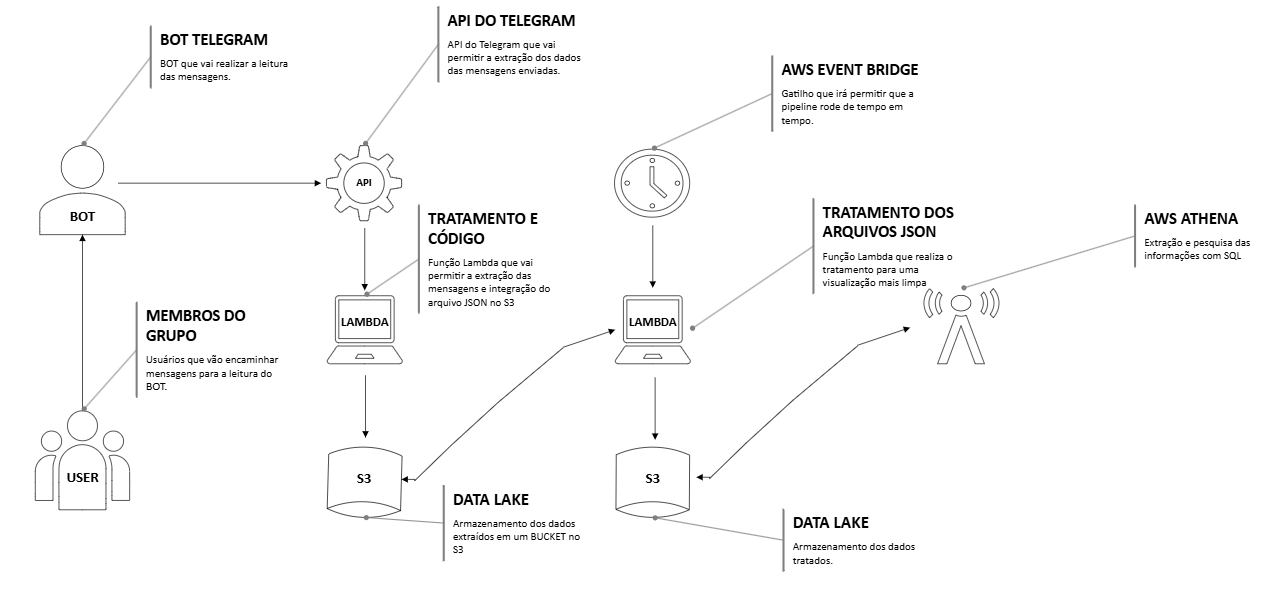

## 2\. Contexto

### **2.1. Chatbot**

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

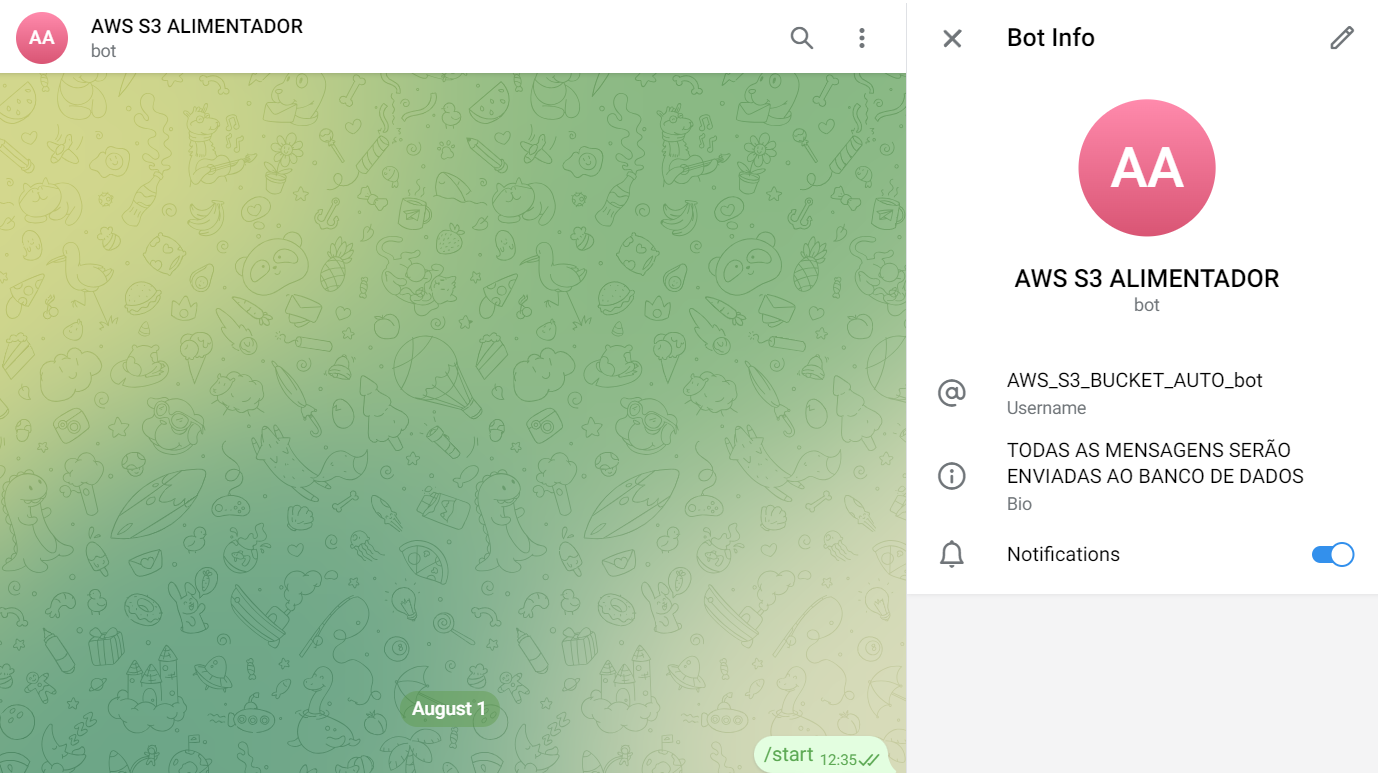

### **2.2. Grupo Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.
Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um **chatbot** para responder perguntas como:

1. Qual o horário que os usuários mais acionam o *bot*?
1. Qual o problema ou dúvida mais frequente?
1. O *bot* está conseguindo resolver os problemas ou esclarecer as dúvidas?
1. Etc.

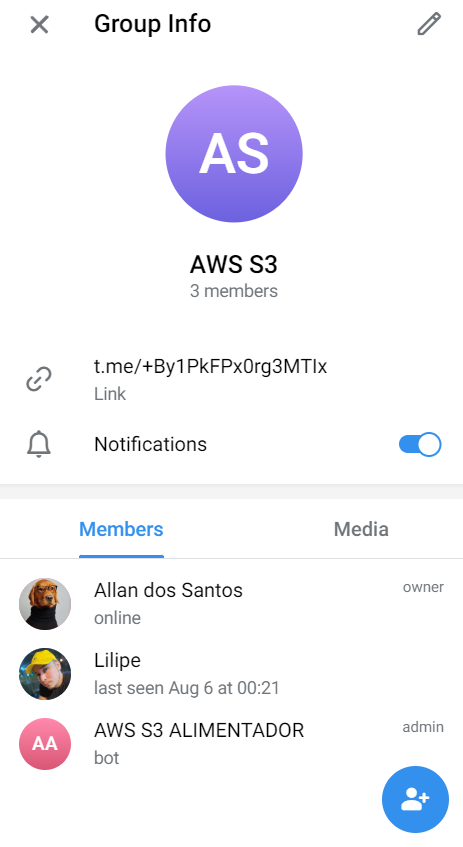


Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

## 3\. Ingestão

### **3.1. Api Gateway**

Uma requisição HTTP contendo o conteúdo da mensagem em seu payload é recebida pelo `AWS API Gateway`, que atua como um intermediário, redirecionando essa requisição para o `AWS Lambda`. O `AWS API Gateway` funciona como o gatilho para o `AWS Lambda`, que, ao ser acionado, processa o payload. O `AWS Lambda` recebe o conteúdo da requisição em seu parâmetro event, e, em seguida, salva esse conteúdo em um arquivo no formato `JSON` (mantendo o conteúdo original, exatamente como recebido no payload). Finalmente, o arquivo JSON é armazenado no `AWS S3`, com uma organização particionada por dia, facilitando o gerenciamento e a consulta dos dados posteriormente.

In [2]:
## EXEMPLO DO ARQUIVO JSON

%%writefile telegram.json
{
    "update_id": 123,
    "message": {
        "message_id": 1,
        "from": {
            "id": 321,
            "is_bot": false,
            "first_name": "Andre"
        },
        "chat": {
            "id": -789,
            "type": "group"
        },
        "date": 1640995200,
        "text": "Ola, mundo!"
    }
}

Overwriting telegram.json


| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

### **3.2. ETL**

Uma vez ao dia, o `AWS Event Bridge` aciona o `AWS Lambda` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no `AWS S3` particionado por dia.

In [3]:
import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  data = data["message"]

In [4]:
print(json.dumps(data, indent=2))

{
  "message_id": 1,
  "from": {
    "id": 321,
    "is_bot": false,
    "first_name": "Andre"
  },
  "chat": {
    "id": -789,
    "type": "group"
  },
  "date": 1640995200,
  "text": "Ola, mundo!"
}


In [5]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [6]:
for k, v in parsed_data.items():
  print(f"{k}: {v}")

message_id: [1]
user_id: [321]
user_is_bot: [False]
user_first_name: ['Andre']
chat_id: [-789]
chat_type: ['group']
date: [1640995200]
text: ['Ola, mundo!']
context_date: ['2024-08-08']
context_timestamp: ['2024-08-08 13:51:40']


In [7]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

In [8]:
table

pyarrow.Table
message_id: int64
user_id: int64
user_is_bot: bool
user_first_name: string
chat_id: int64
chat_type: string
date: int64
text: string
context_date: string
context_timestamp: string
----
message_id: [[1]]
user_id: [[321]]
user_is_bot: [[false]]
user_first_name: [["Andre"]]
chat_id: [[-789]]
chat_type: [["group"]]
date: [[1640995200]]
text: [["Ola, mundo!"]]
context_date: [["2024-08-08"]]
context_timestamp: [["2024-08-08 13:51:40"]]

### **3.3. Ingestão no S3**

A etapa de **ingestão** é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (*schema*). Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos, no formato JSON.

> Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Pode ser conduzida de duas formas:

 - **Batch**: blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;
 - **Streaming**: dados são ingeridos conforme são produzidos e disponibilizados.

No projeto, as mensagens capturadas pelo *bot* podem ser ingeridas através da API *web* de *bots* do **Telegram**, portanto são fornecidos no formato JSON. Como o **Telegram** retem mensagens por apenas 24h em seus servidores, a ingestão via **streaming** é a mais indicada. Para que seja possível esse tipo de **ingestão** seja possível, vamos utilizar um *webhook* (gancho *web*), ou seja, vamos redirecionar as mensagens automaticamente para outra API *web*.

Sendo assim, precisamos de um serviço da AWS que forneça um API *web* para receber os dados redirecionados, o `AWS API Gateway` (documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). Dentre suas diversas funcionalidades, o `AWS API Gateway` permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conecta-lo ao `AWS Lambda`, que pode sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

> Sistemas que reagem a eventos são conhecidos como *event-driven*.

Portanto, foi realizado os seguintes passos:

 - Criar um *bucket* no `AWS S3`;
 - Criar uma função no `AWS Lambda`;
 - Criar uma API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**.

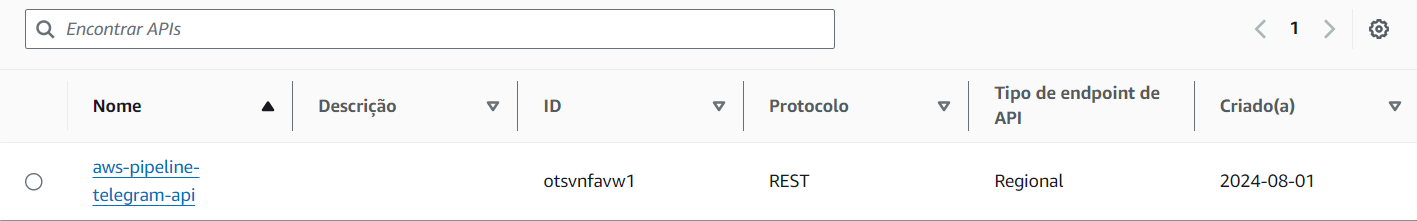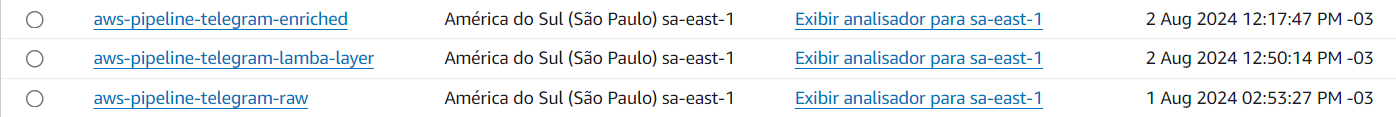

### **3.4. AWS Lambda**

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

> **Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

O código da função:

In [11]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*:

In [12]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` e `AWS_S3_ENRICHED` com os nomes dos *bucket* do `AWS S3` da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

 - **Permissão**

Precisamos adicionar a permissão de escrita nos *buckets* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

 - **Recursos**

O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos. Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (*input/output*) de arquivos do `AWS S3`.

 - **Camadas**

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou *layers*, onde podemos fazer o *upload* dos pacotes Python direto na plataforma ou através de um *bucket* do `AWS S3`. Vamos então seguir com a última opção, onde teremos que:

 - Criar um *bucket* no `AWS S3`;
 - Fazer o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criar *layer* e conectar na função.

### **3.4. AWS Event Bridge**

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

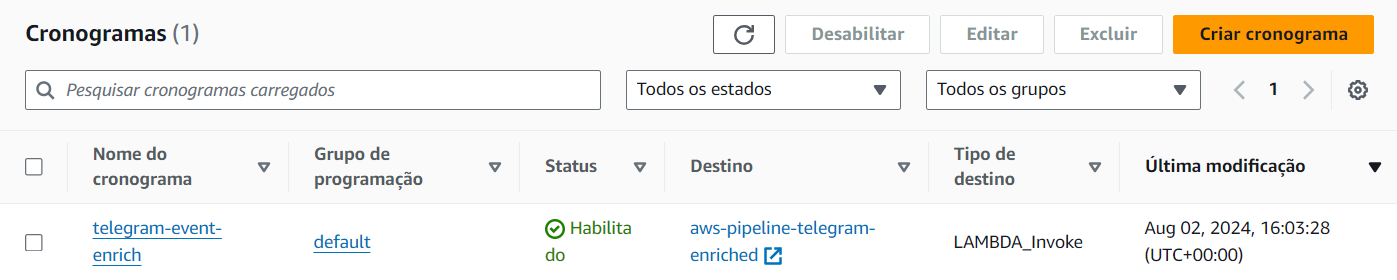

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

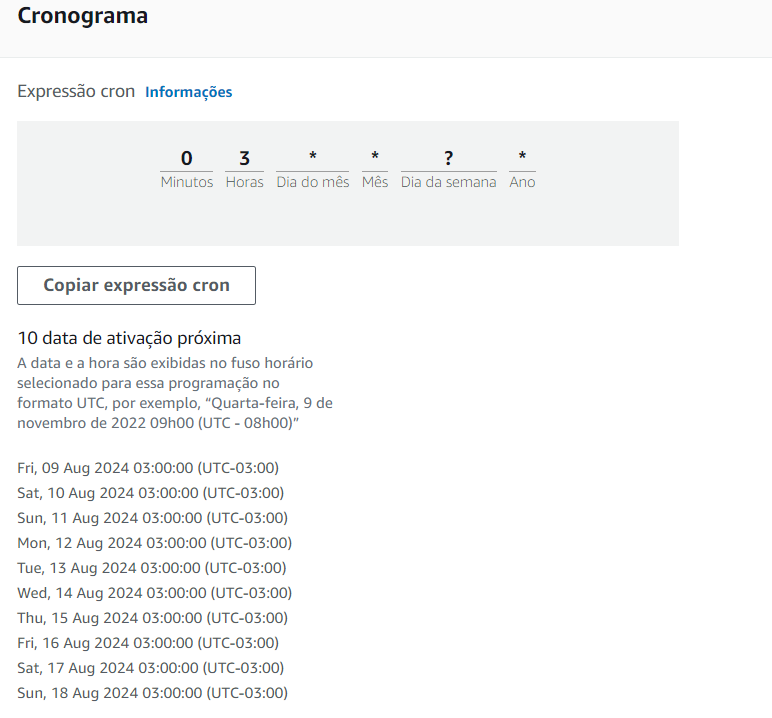

## 4\. Apresentação SQL

### **4.1. SQL**

Na etapa de **apresentação SQL**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

### **4.2. Apresentação dos dados**

> **Importante**: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o `AWS Athena` para que a ela esteja disponível via SQL. Para isso, use o comando SQL `MSCK REPAIR TABLE <nome-tabela>` para todas as partições (mais caro) ou `ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>` para uma única partição (mais barato), documentação neste [link](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html)).

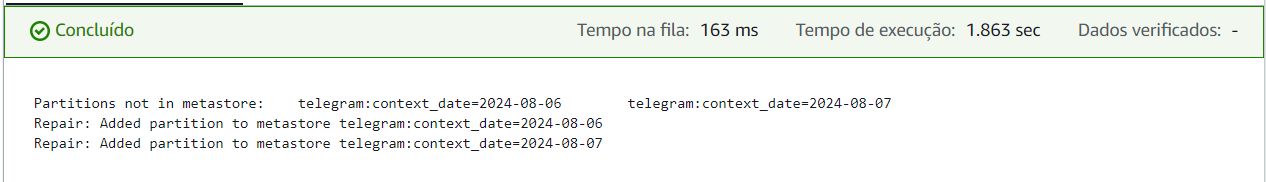

Agora vamos iniciar as consultas em SQL para ver os resultados

- Verificando se a tabela foi criada de maneira correta.

```sql
SELECT * FROM `telegram` LIMIT 10;
```

In [16]:
#RESULTADO DA CONSULTA

pd.read_csv('https://raw.githubusercontent.com/allansantos881/awssqlprojeto/main/limit%2010.csv')

,message_id,user_id,user_is_bot,user_first_name,chat_id,chat_type,text,date,context_date
0,37,1548813629,False,Allan,-1002154914785,supergroup,Go RNS,1723035473,2024-08-07
1,34,1548813629,False,Allan,-1002154914785,supergroup,Bom dia,1722862738,2024-08-05
2,35,1957472898,False,Fhilipe,-1002154914785,supergroup,Vai dormir,1722862755,2024-08-05
3,12,1957472898,False,Fhilipe,-1002154914785,supergroup,Bom dia,1722602225,2024-08-02
4,13,1548813629,False,Allan,-1002154914785,supergroup,Bumdinha,1722613118,2024-08-02
5,36,1548813629,False,Allan,-1002154914785,supergroup,Brasil tá amassando,1722978023,2024-08-06
6,33,1548813629,False,Allan,-1002154914785,supergroup,Importante,1722818650,2024-08-04
7,27,1548813629,False,Allan,-1002154914785,supergroup,Ksksksksks,1722705639,2024-08-03
8,30,1548813629,False,Allan,-1002154914785,supergroup,"Me ajude, sozinho em penso merda pra carai",1722705696,2024-08-03
9,31,1548813629,False,Allan,-1002154914785,supergroup,Sou rei delas,1722731850,2024-08-03


- Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

In [18]:
#RESULTADO DA CONSULTA

pd.read_csv("https://raw.githubusercontent.com/allansantos881/awssqlprojeto/main/msg%20por%20dia.csv")

,context_date,message_amount
0,2024-08-07,1
1,2024-08-06,1
2,2024-08-05,2
3,2024-08-04,1
4,2024-08-03,6
5,2024-08-02,2


- Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

In [17]:
#RESULTADO DA CONSULTA

pd.read_csv("https://raw.githubusercontent.com/allansantos881/awssqlprojeto/main/msg%20por%20usuario.csv")

,user_id,user_first_name,context_date,message_amount
0,1548813629,Allan,2024-08-07,1
1,1548813629,Allan,2024-08-06,1
2,1548813629,Allan,2024-08-05,1
3,1957472898,Fhilipe,2024-08-05,1
4,1548813629,Allan,2024-08-04,1
5,1957472898,Fhilipe,2024-08-03,1
6,1548813629,Allan,2024-08-03,5
7,1548813629,Allan,2024-08-02,1
8,1957472898,Fhilipe,2024-08-02,1


- Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

In [19]:
#RESULTADO DA CONSULTA

pd.read_csv("https://raw.githubusercontent.com/allansantos881/awssqlprojeto/main/media%20tamanho%20msg.csv")

,user_id,user_first_name,context_date,average_message_length
0,1548813629,Allan,2024-08-07,6
1,1548813629,Allan,2024-08-06,19
2,1548813629,Allan,2024-08-05,7
3,1957472898,Fhilipe,2024-08-05,10
4,1548813629,Allan,2024-08-04,10
5,1957472898,Fhilipe,2024-08-03,12
6,1548813629,Allan,2024-08-03,23
7,1548813629,Allan,2024-08-02,8
8,1957472898,Fhilipe,2024-08-02,7


- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

In [20]:
pd.read_csv("https://raw.githubusercontent.com/allansantos881/awssqlprojeto/main/por%20dia%20da%20semana.csv")

,parsed_date_hour,parsed_date_weekday,parsed_date_weeknum,message_amount
0,15,5,31,1
1,12,5,31,1
2,17,6,31,4
3,0,7,31,2
4,0,1,32,1
5,12,1,32,2
6,21,2,32,1
7,12,3,32,1
